initiate the 

In [2]:
import os, sys, json
from pathlib import Path

# 让 Python 能 import src 里的包
sys.path.append(os.path.abspath("../src"))

from datapipe.json_schema import csv_bytes_to_llm_json
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# 载入一个测试 dataset（跟上一个 notebook 用同一个 CSV 就行）
csv_path = Path("../data/sample_sales.csv")  # 或 sample_sales
file_bytes = csv_path.read_bytes()
dataset_json = csv_bytes_to_llm_json(file_bytes, dataset_name="sample_sales")

meta = dataset_json["meta"]
meta

{'row_count': 7,
 'column_count': 7,
 'columns': [{'name': 'order_id',
   'dtype': 'int',
   'nullable': False,
   'example_values': ['1001', '1002', '1003'],
   'summary': {'min': 1001.0, 'max': 1007.0, 'mean': 1004.0}},
  {'name': 'customer',
   'dtype': 'string',
   'nullable': False,
   'example_values': ['Alice', 'Bob', 'Cindy']},
  {'name': 'category',
   'dtype': 'string',
   'nullable': False,
   'example_values': ['Electronics', 'Clothing', 'Electronics']},
  {'name': 'price',
   'dtype': 'float',
   'nullable': False,
   'example_values': ['120.5', '45.0', '89.9'],
   'summary': {'min': 45.0, 'max': 950.0, 'mean': 240.05714285714288}},
  {'name': 'cost',
   'dtype': 'float',
   'nullable': False,
   'example_values': ['85.0', '20.0', '70.0'],
   'summary': {'min': 20.0, 'max': 780.0, 'mean': 172.85714285714286}},
  {'name': 'profit',
   'dtype': 'float',
   'nullable': False,
   'example_values': ['35.5', '25.0', '19.9'],
   'summary': {'min': 19.9, 'max': 170.0, 'mean': 67.2

In [3]:
def suggest_questions_from_meta(meta: dict, client: OpenAI) -> str:
    prompt = f"""
You are a senior data analyst.

Here is the metadata of a dataset:

{json.dumps(meta, indent=2)}

Based on the columns, types, and example values, propose 5 clear,
beginner-friendly analysis questions that a non-technical user might be interested in.
Number them 1 to 5.
Only output the questions, no explanations.
"""
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
    )

    return response.choices[0].message.content

In [4]:
questions_text = suggest_questions_from_meta(meta, client)
print(questions_text)

1. What is the total profit made from all orders in the dataset?  
2. How many unique customers placed orders?  
3. Which product category generated the highest average price?  
4. What is the trend of profit over the dates provided in the dataset?  
5. Who are the top three customers based on the total amount spent?  


In [5]:
print(questions_text)
chosen_index = 3  # 假设你选了第 3 个问题

# 非严格解析：简单从文本里 split 一下（后面我们再优化）
questions_lines = [line.strip() for line in questions_text.split("\n") if line.strip()]
chosen_question_line = questions_lines[chosen_index - 1]
chosen_question_line

1. What is the total profit made from all orders in the dataset?  
2. How many unique customers placed orders?  
3. Which product category generated the highest average price?  
4. What is the trend of profit over the dates provided in the dataset?  
5. Who are the top three customers based on the total amount spent?  


'3. Which product category generated the highest average price?'

In [6]:
def generate_chart_spec_from_question(meta: dict, question: str, client: OpenAI) -> dict:
    prompt = f"""
You are a data visualization assistant.

You are given:
1) Dataset metadata:
{json.dumps(meta, indent=2)}

2) A user's analysis question:
\"\"\"{question}\"\"\" 

Your task:
- Decide the most appropriate chart type (one of: "line", "bar", "scatter", "histogram").
- Decide which column to use on the x-axis.
- Decide which column to use on the y-axis.
- Decide if aggregation is needed (e.g. sum, mean, count).
- Optionally decide a group_by column (for multiple lines/bars).
- Optionally specify simple filters.

Return ONLY a JSON object with this structure and nothing else:

{{
  "chart_type": "line | bar | scatter | histogram",
  "x": "column_name",
  "y": "column_name",
  "aggregation": "sum | mean | count | none",
  "group_by": "column_name or null",
  "filters": [
    {{
      "column": "column_name",
      "op": "== | != | > | < | >= | <=",
      "value": "literal_value"
    }}
  ]
}}
"""

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        response_format={"type": "json_object"},  # 要求它一定返回 JSON
    )

    content = response.choices[0].message.content
    spec = json.loads(content)
    return spec

In [7]:
chart_spec = generate_chart_spec_from_question(meta, chosen_question_line, client)
chart_spec

{'chart_type': 'bar',
 'x': 'category',
 'y': 'price',
 'aggregation': 'mean',
 'group_by': None,
 'filters': []}

In [8]:
import pandas as pd
from pathlib import Path

csv_path = Path("../data/sample_sales.csv")  
df = pd.read_csv(csv_path)

df.head()

,order_id,customer,category,price,cost,profit,date
0,1001,Alice,Electronics,120.5,85.0,35.5,2024-01-01
1,1002,Bob,Clothing,45.0,20.0,25.0,2024-01-02
2,1003,Cindy,Electronics,89.9,70.0,19.9,2024-01-03
3,1004,David,Furniture,220.0,160.0,60.0,2024-01-04
4,1005,Emma,Clothing,130.0,55.0,75.0,2024-01-05


tools for excute the chart_spec

In [9]:
import matplotlib.pyplot as plt

def execute_chart_spec(df: pd.DataFrame, spec: dict):
    """
    根据 chart_spec 对 df 做聚合并画图。
    目前支持:
    - chart_type: bar, line, scatter, histogram
    - aggregation: sum, mean, count, none
    """
    chart_type = spec.get("chart_type")
    x_col = spec.get("x")
    y_col = spec.get("y")
    agg = spec.get("aggregation", "none")
    group_by = spec.get("group_by")
    filters = spec.get("filters", [])

    # 1. 简单过滤（如果有的话）
    filtered_df = df.copy()
    for f in filters:
        col = f["column"]
        op = f["op"]
        val = f["value"]
        if op == "==":
            filtered_df = filtered_df[filtered_df[col] == val]
        elif op == "!=":
            filtered_df = filtered_df[filtered_df[col] != val]
        elif op == ">":
            filtered_df = filtered_df[filtered_df[col] > val]
        elif op == "<":
            filtered_df = filtered_df[filtered_df[col] < val]
        elif op == ">=":
            filtered_df = filtered_df[filtered_df[col] >= val]
        elif op == "<=":
            filtered_df = filtered_df[filtered_df[col] <= val]

    # 2. 确保 y 列是数值
    filtered_df[y_col] = pd.to_numeric(filtered_df[y_col], errors="coerce")

    # 3. 做聚合（如果需要）
    if agg != "none":
        group_cols = [x_col]
        if group_by is not None:
            group_cols.append(group_by)

        if agg == "sum":
            agg_df = filtered_df.groupby(group_cols, dropna=False)[y_col].sum().reset_index()
        elif agg == "mean":
            agg_df = filtered_df.groupby(group_cols, dropna=False)[y_col].mean().reset_index()
        elif agg == "count":
            agg_df = filtered_df.groupby(group_cols, dropna=False)[y_col].count().reset_index()
        else:
            raise ValueError(f"Unsupported aggregation: {agg}")
    else:
        agg_df = filtered_df.copy()

    # 4. 画图
    plt.figure(figsize=(6, 4))

    if chart_type == "bar":
        plt.bar(agg_df[x_col], agg_df[y_col])
        plt.xlabel(x_col)
        plt.ylabel(f"{agg}({y_col})" if agg != "none" else y_col)
        plt.xticks(rotation=45)
        plt.tight_layout()

    elif chart_type == "line":
        plt.plot(agg_df[x_col], agg_df[y_col])
        plt.xlabel(x_col)
        plt.ylabel(f"{agg}({y_col})" if agg != "none" else y_col)
        plt.xticks(rotation=45)
        plt.tight_layout()

    elif chart_type == "scatter":
        plt.scatter(agg_df[x_col], agg_df[y_col])
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.xticks(rotation=45)
        plt.tight_layout()

    elif chart_type == "histogram":
        plt.hist(agg_df[y_col])
        plt.xlabel(y_col)
        plt.ylabel("count")
        plt.tight_layout()

    else:
        raise ValueError(f"Unsupported chart_type: {chart_type}")

    plt.show()

    return agg_df  # 顺便把用于画图的数据返回，方便你检查

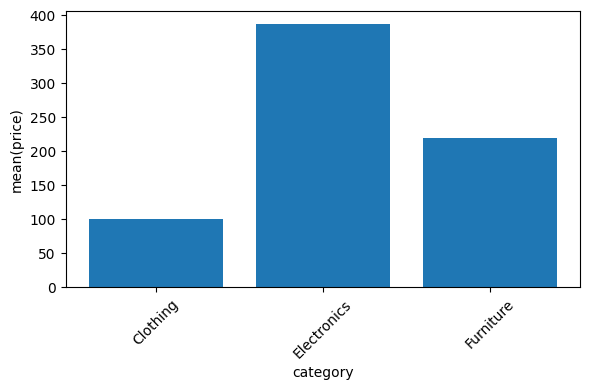

,category,price
0,Clothing,100.0
1,Electronics,386.8
2,Furniture,220.0


In [10]:
agg_df = execute_chart_spec(df, chart_spec)
agg_df